In [219]:
!pip install torch-lr-finder

In [220]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch_lr_finder import LRFinder
import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import time

USE_GPU = True
dtype = torch.float32


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print_every = 150
print('using device:', device)
np.random.seed(123)
torch.manual_seed(123)


using device: cuda


In [221]:

NUM_TRAIN = 50000

transform = T.Compose([
                T.ToTensor(),
            ])

mnist_train = dset.FashionMNIST(root='data', download=True, train=True, transform=transform)

loader_train = DataLoader(mnist_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

mnist_val = dset.FashionMNIST('data', download=True, train=True, transform=transform)

loader_val = DataLoader(mnist_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 60000)))

mnist_test = dset.FashionMNIST('data', download=True, train=False, transform=transform)

loader_test = DataLoader(mnist_test, batch_size=64)


9


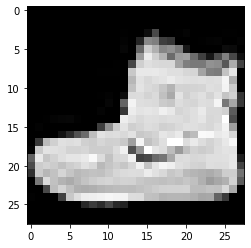

In [222]:
a = next(iter(mnist_train))
a[0].size()
len(mnist_train)
image, label = next(iter(mnist_train))
plt.imshow(image.squeeze(), cmap="gray")
print(label)


In [235]:
class MyModel_1(nn.Module):
    def __init__(self, learning_rate=0.001):
        super().__init__()
        self.lr = learning_rate

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_1 = nn.Linear(6*6*64, 1000, device=device) 
        self.dropout = nn.Dropout(0.25)
        self.fc_2 = nn.Linear(1000, 100, device=device)
        self.fc_3 = nn.Linear(100, 10, device=device)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.fc_3(self.fc_2(self.dropout(self.fc_1(out.view(out.size(0), -1)))))
        return out

    def get_accuracy(self, loader):
        num_correct = 0
        num_samples = 0
        self.eval()  # set model to evaluation mode
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
                y = y.to(device=device, dtype=torch.long)
                scores = self.forward(x)
                _, preds = scores.max(1)
                num_correct += (preds == y).sum()
                num_samples += preds.size(0)
            acc = float(num_correct) / num_samples * 100
        return acc
    
    def train_step(self, epoch, batch, schedule=False):
        self.train()
        loss_func = nn.CrossEntropyLoss()
        optimizer = self.create_optimizer()
        if schedule:
            scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                            max_lr=0.1, 
                                                            steps_per_epoch=len(batch), 
                                                            epochs=1, three_phase=True, 
                                                            pct_start=0.45, 
                                                            div_factor=10, 
                                                            final_div_factor=10)
        for i, (images, labels) in enumerate(batch):
            if i % print_every == 0:
                try:
                    print(scheduler.get_last_lr())
                except:
                    pass
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            out = self(images)
            loss = loss_func(out, labels)
            loss.backward()
            optimizer.step()
            try:
                scheduler.step()
            except:
                pass
            if i % print_every == 0:   
                print(f'Epoch {epoch} Iteration %d, loss = %.4f' % (i, loss.item()))
                print(f'Accuracy train = {self.get_accuracy(batch)}')
                print()

    def create_optimizer(self):
          optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=0.9)
          return optimizer

In [224]:
def constant_lr(num_epochs=1):
    model = None
    learning_rate = 0.028
    model = MyModel_1(learning_rate)
    model.to(device)
    print('Learning rate = ' + str(learning_rate))
    for epoch in range(num_epochs):
        model.train_step(epoch, loader_train)

    print(model.get_accuracy(loader_val))
    print(model.get_accuracy(loader_test))


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.01E-02


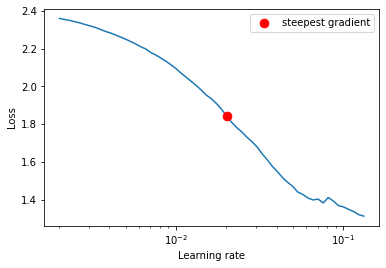

In [225]:
model = MyModel_1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(loader_train, end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [226]:
def scheduler_lr(num_epochs=1):
    model = MyModel_1()
    model.to(device)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        model.train_step(epoch, loader_train, schedule=True)

    print(model.get_accuracy(loader_val))
    print(model.get_accuracy(loader_test))

In [236]:
scheduler_lr()

[0.009999999999999995]
Epoch 0 Iteration 0, loss = 2.2667
Accuracy train = 12.026

[0.04483511636944632]
Epoch 0 Iteration 150, loss = 0.6233
Accuracy train = 78.61200000000001

[0.09540778403454675]
Epoch 0 Iteration 300, loss = 0.7725
Accuracy train = 81.218

[0.0834200135185409]
Epoch 0 Iteration 450, loss = 0.5465
Accuracy train = 85.542

[0.027431599529663488]
Epoch 0 Iteration 600, loss = 0.3330
Accuracy train = 87.24199999999999

[0.003994504384248846]
Epoch 0 Iteration 750, loss = 0.3313
Accuracy train = 89.56

89.19
88.42


In [237]:
constant_lr()

Learning rate = 0.028
Epoch 0 Iteration 0, loss = 2.3588
Accuracy train = 10.76

Epoch 0 Iteration 150, loss = 0.4727
Accuracy train = 78.18

Epoch 0 Iteration 300, loss = 0.6244
Accuracy train = 83.804

Epoch 0 Iteration 450, loss = 0.2723
Accuracy train = 86.236

Epoch 0 Iteration 600, loss = 0.2881
Accuracy train = 86.55199999999999

Epoch 0 Iteration 750, loss = 0.2987
Accuracy train = 87.22

86.77
85.97


In [233]:
scheduler_lr(10)

[0.009999999999999995]
Epoch 0 Iteration 0, loss = 2.3591
Accuracy test = 10.0

[0.04483511636944632]
Epoch 0 Iteration 150, loss = 0.7405
Accuracy test = 76.97

[0.09540778403454675]
Epoch 0 Iteration 300, loss = 0.4118
Accuracy test = 82.67999999999999

[0.0834200135185409]
Epoch 0 Iteration 450, loss = 0.2667
Accuracy test = 83.19

[0.027431599529663488]
Epoch 0 Iteration 600, loss = 0.2486
Accuracy test = 86.14

[0.003994504384248846]
Epoch 0 Iteration 750, loss = 0.3231
Accuracy test = 88.14999999999999

[0.009999999999999995]
Epoch 1 Iteration 0, loss = 1.3096
Accuracy test = 88.37

[0.04483511636944632]
Epoch 1 Iteration 150, loss = 0.3271
Accuracy test = 86.82

[0.09540778403454675]
Epoch 1 Iteration 300, loss = 0.6072
Accuracy test = 85.59

[0.0834200135185409]
Epoch 1 Iteration 450, loss = 0.2564
Accuracy test = 86.38

[0.027431599529663488]
Epoch 1 Iteration 600, loss = 0.1888
Accuracy test = 88.14999999999999

[0.003994504384248846]
Epoch 1 Iteration 750, loss = 0.2887
Accu

In [234]:
constant_lr(10)

Learning rate = 0.028
Epoch 0 Iteration 0, loss = 2.3283
Accuracy test = 18.59

Epoch 0 Iteration 150, loss = 0.4429
Accuracy test = 77.16

Epoch 0 Iteration 300, loss = 0.4113
Accuracy test = 82.99

Epoch 0 Iteration 450, loss = 0.6049
Accuracy test = 84.77

Epoch 0 Iteration 600, loss = 0.3490
Accuracy test = 83.83

Epoch 0 Iteration 750, loss = 0.4229
Accuracy test = 85.81

Epoch 1 Iteration 0, loss = 0.7928
Accuracy test = 85.77

Epoch 1 Iteration 150, loss = 0.2555
Accuracy test = 85.81

Epoch 1 Iteration 300, loss = 0.3757
Accuracy test = 87.79

Epoch 1 Iteration 450, loss = 0.4229
Accuracy test = 88.4

Epoch 1 Iteration 600, loss = 0.4283
Accuracy test = 88.28

Epoch 1 Iteration 750, loss = 0.3379
Accuracy test = 87.33

Epoch 2 Iteration 0, loss = 0.7022
Accuracy test = 87.22999999999999

Epoch 2 Iteration 150, loss = 0.2411
Accuracy test = 87.02

Epoch 2 Iteration 300, loss = 0.3230
Accuracy test = 87.55

Epoch 2 Iteration 450, loss = 0.3036
Accuracy test = 89.01

Epoch 2 Itera